In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt

sys.path.append("..")
import utils

import Bio.Data.CodonTable

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

import pandas as pd

In [2]:
MAX_TOKEN_LENGTH = 510
BATCH_SIZE=60
BIF_BATCH_SIZE=80
num_masks = 3

TEST_SEQ = 1
TRAIN_CUTOFF = 3000
TEST_TOKEN = 0

DEVICE = "cuda"

In [3]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt")

model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
dataset = DNADataset(f"../data/training_spike.fasta")
sequences = [utils.get_genome(np.dot(x[0], np.arange(len(ALPHABET)))) for x in dataset]
names = [x[1] for x in dataset]
print("done extracting sequences!")

x = Bio.Data.CodonTable.standard_dna_table
str_seqs = ["".join(x).replace("-","") for x in sequences]
codons = [[x[num_masks * i:3 * (i+1)] for i in range(len(x) // 3)] for x in str_seqs]
aa_drop_na = [[s for s in "".join([x.forward_table.get(s,"") for s in seq][:MAX_TOKEN_LENGTH])] for seq in codons]
print("done extracting AAs!")

# metadata = pd.read_csv(f"../data/all_data/all_metadata.tsv", sep="\t")
# clade_labels = [metadata.loc[metadata.name == names[i], "clade_membership"].values[0] for i in range(len(names))]
# print("done getting clade labels!")

done extracting sequences!
done extracting AAs!


In [5]:
unique_aa_seqs = list(np.unique(["".join(x) for x in aa_drop_na]))
train_data = tokenizer(text=["".join(x) for x in aa_drop_na][:TRAIN_CUTOFF], return_tensors="pt", add_special_tokens=False, truncation=False, padding=True)["input_ids"]
bif_data = tokenizer(text=unique_aa_seqs, return_tensors="pt", add_special_tokens=False, truncation=False, padding=True)["input_ids"]

num_obs = len(bif_data)
num_data = len(bif_data)

In [6]:
def collate_fn(batch, data_collator=data_collator, device=DEVICE):
    batch = torch.stack(batch, dim=0)
    inputs, labels = data_collator.torch_mask_tokens(batch)
    return inputs.to(device), labels.to(DEVICE)

sgld_dataloader = torch.utils.data.DataLoader(train_data, collate_fn=collate_fn, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
bif_dataloader = torch.utils.data.DataLoader(bif_data, collate_fn=collate_fn, shuffle=False, batch_size=BIF_BATCH_SIZE, drop_last=False)

In [7]:
def get_vals(
    model, 
    dataloader=bif_dataloader, 
    vocab_size=tokenizer.vocab_size,
    num_data = len(unique_aa_seqs),
    batch_size = BIF_BATCH_SIZE
):  
    ret_vec = torch.zeros(num_data)

    with torch.no_grad():
        for i, (b_input, b_label) in enumerate(dataloader):
            bsize = b_input.shape[0]
            outputs = model(b_input, attention_mask=torch.ones_like(b_input))["logits"]
            batch_loss = torch.sum(nn.functional.cross_entropy(outputs.view(-1,vocab_size), target=b_label.view(-1), ignore_index=-100, reduction="none").view(bsize, -1), dim=-1)
    
            if i < len(dataloader) - 1:
                ret_vec[i * batch_size : (i+1) * batch_size] = batch_loss
            else:
                ret_vec[i * batch_size:] = batch_loss

    return ret_vec

In [8]:
def evaluate_function(
    model: nn.Module, 
    data: torch.Tensor, 
    device=DEVICE, 
) -> EvalResults:
    
    """
    model (torch.nn.module): ESM model
    data (torch.Tensor): minibatch data used to update weights of model in SGLD
    device (String): either "cuda" or "cpu"

    returns:
    dictionary with 
    (i) loss - loss used to update weights of model
    (ii) obs - calculated observables (in this case cross-entropy loss on one test token) as described above
    (iii) loss_vec - the losses evaluated at every training point for the model used to compute the BIF as described in the algorithm at the top
    """
    
    inputs, targets = data
    return {
        "loss": model(inputs, labels=targets).loss,
        "obs": get_vals(model=model),
        "loss_vec": get_vals(model=model)
    }

In [9]:
ESM_BIF = estimate_bif(
    model=model,
    loader = sgld_dataloader,
    evaluate = evaluate_function,
    num_obs=num_obs,
    device=DEVICE,
    num_chains=4,
    num_draws=50,
    num_data=num_data
)

/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:262: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:311: UserWarning: If you're setting a nbeta or temperature in sampling_method_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
Chain 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:54<00:00,  4.68s/it]


## Visualizations

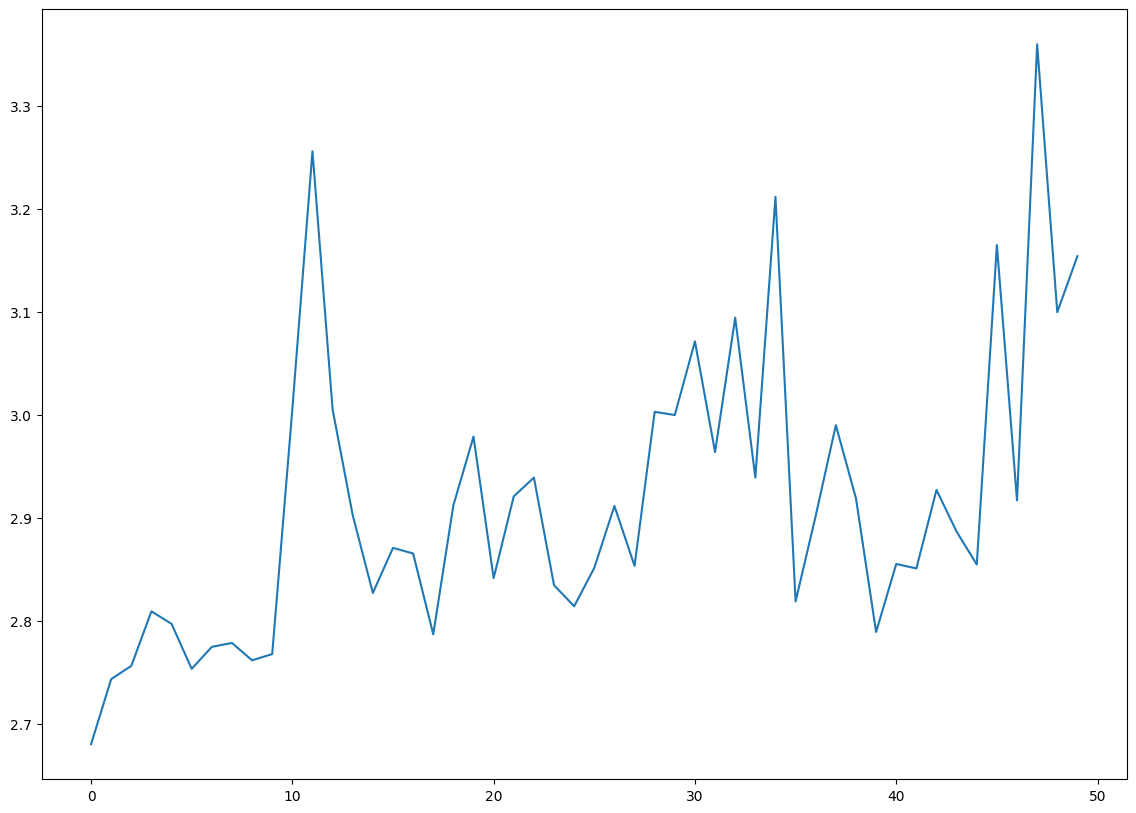

In [12]:
fig, arr = plt.subplots(1,1,figsize=(14,10))

losses = ESM_BIF["sgld_loss/trace"]
arr.plot(np.arange(losses.shape[1]), losses[0])
plt.show()

In [20]:
# lower_tri_indices = torch.torch.tril_indices(num_data,num_data,offset=0)

computed_bif = ESM_BIF["BIF"]
hamming_dist = torch.sum(torch.ne(bif_data[None,:,:], bif_data[:,None,:]), dim=-1).numpy()

# computed_bif = np.diag(computed_bif)
# hamming_dist = np.diag(hamming_dist)

computed_bif = computed_bif[lower_tri_indices[0], lower_tri_indices[1]]
hamming_dist = hamming_dist[lower_tri_indices[0], lower_tri_indices[1]]

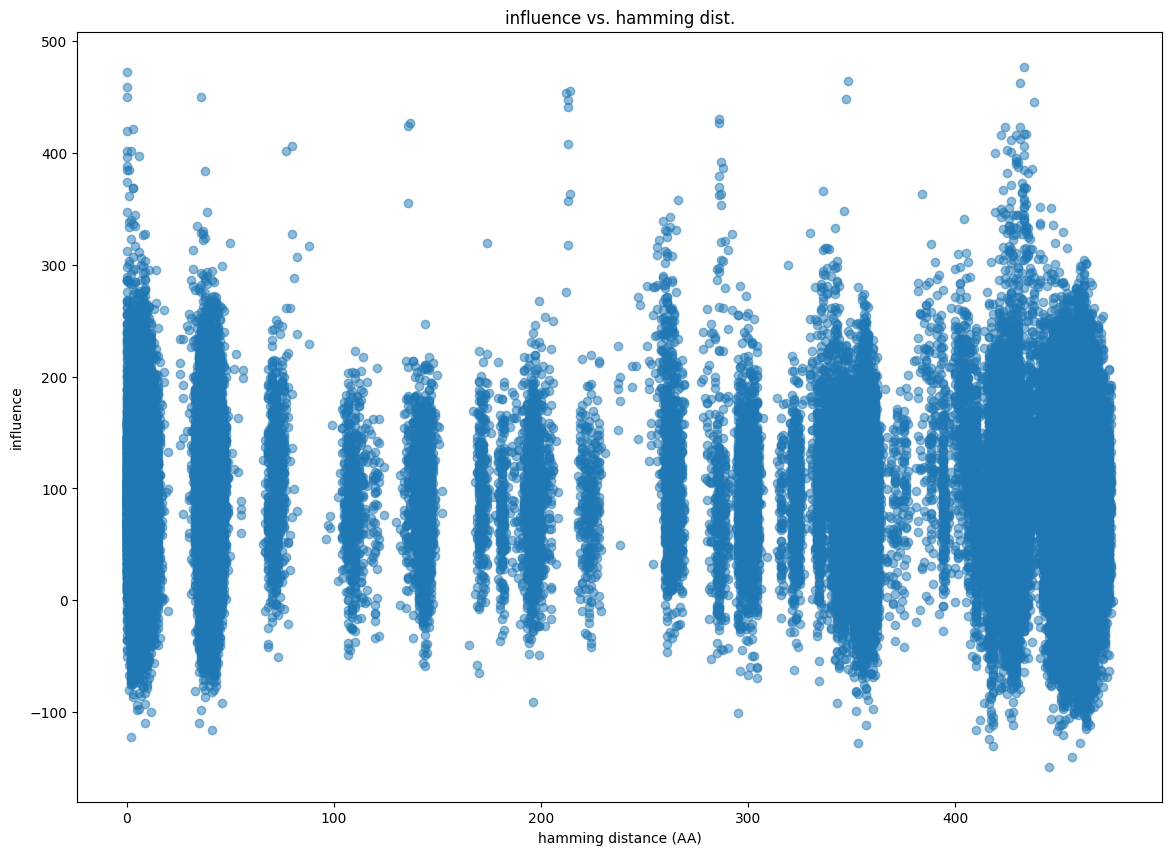

In [21]:
fig,ax = plt.subplots(1,1,figsize=(14,10))
ax.scatter(hamming_dist, computed_bif, alpha=0.5)
ax.set_xlabel("hamming distance (AA)")
ax.set_ylabel("influence")
ax.set_title("influence vs. hamming dist.")
plt.show()